In [286]:
%matplotlib inline
import re
import numpy as np
import pandas as pd

from IPython.display import display, HTML
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime

In [410]:
def extract(string, key, dtype):
    if dtype is bool:
        return True if re.search(' {}=((True)|(False)) '.format(key), string).group(1) == 'True' else False
    if dtype is float:
        return float(re.search(' {}=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?)'.format(key), string).group(1))
    if dtype is int:
        return float(re.search(' {}=(\d+) '.format(key), string).group(1))

def get_result_metrics(filepath):
    # get lines with results
    lines = []
    marker = 'Got result: '
    with open(filepath) as f:
        for line in f.readlines():
            if marker in line:
                lines.append(line.split(marker, 1)[1])
    
    # extract metrics
    runs = []
    for run in lines:
        data = {
            #'success': extract(run, 'success', bool),
            'time_created': extract(run, 'time_created', float),
            'time_input_received': extract(run, 'time_input_received', float),
            'time_compute_started': extract(run, 'time_compute_started', float),
            'time_result_sent': extract(run, 'time_result_sent', float),
            'time_result_received': extract(run, 'time_result_received', float),
            'time_running': extract(run, 'time_running', float),
            'time_serialize_inputs': extract(run, 'time_serialize_inputs', float),
            'time_deserialize_inputs': extract(run, 'time_deserialize_inputs', float),
            'time_serialize_results': extract(run, 'time_serialize_results', float),
            'time_deserialize_results': extract(run, 'time_deserialize_results', float),
            'time_result_received': extract(run, 'time_result_received', float),
        }
        

        
        data['client_to_method_server'] = data['time_input_received'] - (
                data['time_created'] + data['time_serialize_inputs'])
        data['worker_to_method_server'] = data['time_result_sent'] - (
                data['time_compute_started'] + data['time_running'] + 
                data['time_deserialize_inputs'] + data['time_serialize_results'])
        data['method_server_to_client'] = data['time_result_received'] - (
                data['time_result_sent'] + data['time_deserialize_results'])
        data['time_serialization'] = sum(data[key] for key in data if 'serialize' in key)
        data['time_created_to_result_received'] = data['time_result_received'] - data['time_created']
        
        runs.append(data)
    
    return pd.DataFrame(runs)

def aggregate_runs(run_paths):
    data = []
    for path in run_paths:
        results = pd.Series({'path': path})

        with open(path) as f:
            first_line = f.readline()
            timestamp = first_line.split(' - ')[0]
            value_server = True if re.search('use_value_server=(.+),', first_line).group(1) == 'True' else False
            results['value_server'] = value_server
            results['task_count'] = int(re.search('task_count=(\d+),', first_line).group(1))
            results['task_input_size'] = int(re.search('task_input_size=(\d+),', first_line).group(1))
            results['task_interval'] = float(re.search('task_interval=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?),', first_line).group(1))
            results['task_output_size'] = int(re.search('task_output_size=(\d+),', first_line).group(1))
            results['time_start'] = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S,%f").timestamp()
            
            to_proxy_times = []
            for line in f.readlines():
                if 'to_proxy_time=' in line:
                    to_proxy_times.append(extract(line, 'to_proxy_time', float))
            results['to_value_server_time'] = np.median(to_proxy_times) if len(to_proxy_times) > 0 else 0

        function_results = get_result_metrics(path)
        results['n_tasks'] = len(function_results.index)
        results['total'] = None
        results = pd.concat([results, function_results.median()])
                
        data.append(results)
        
    return pd.concat(data, axis=1).T

In [411]:
cols = ['client_to_method_server', 'worker_to_method_server', 'method_server_to_client', 'time_serialization', 'to_value_server_time', 'time_running', 'total']
ind = np.arange(len(cols))
width = 0.35

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/unique_data/no_value_server/2021-02-12_20...,False,100,10,1,0,1.61316e+09,0,100,0.006233,...,5.354e-05,6.36195e-05,0.000298282,0.000431643,7.29215e-05,0.000617623,0.00394583,0.000734448,0.000881575,0.0219585
1,runs/unique_data/value_server/2021-02-12_20-07...,True,100,10,1,0,1.61316e+09,0.000251532,100,0.006199,...,0.00111787,3.4194e-05,0.000175222,0.000206326,3.21e-05,0.000500917,0.0034579,0.000421524,0.000449143,73.1147


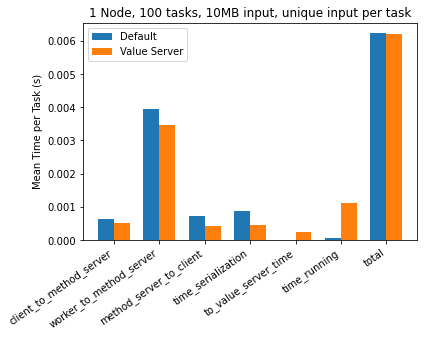

In [412]:
rundir = 'runs/unique_data/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 100 tasks, 10MB input, unique input per task')
plt.ylabel('Mean Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/reuse_data/2021-02-12_20-39-06/runtime.log,False,100,10,1,0,1.61316e+09,0,100,0.005690,...,5.129e-05,6.36575e-05,0.000301397,0.000424098,6.77675e-05,0.000543237,0.00356722,0.000664949,0.000863458,0.0192355
1,runs/reuse_data/2021-02-12_20-41-23/runtime.log,True,100,10,1,0,1.61316e+09,0.00026536,100,0.006207,...,0.00121129,3.36085e-05,0.000160651,0.000204462,3.5213e-05,0.000512719,0.00332224,0.000457287,0.000438449,65.1952


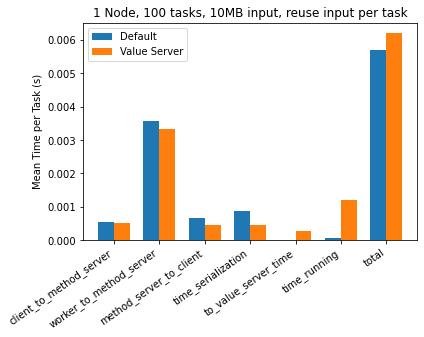

In [413]:
rundir = 'runs/reuse_data/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 100 tasks, 10MB input, reuse input per task')
plt.ylabel('Mean Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/reuse_data_async/2021-02-12_21-24-55/runt...,True,100,10,1,0,1.61317e+09,0.000336885,100,0.008767,...,0.00263959,3.9525e-05,0.000163231,0.000203682,5.59855e-05,0.00051415,0.0041362,0.000673771,0.000466142,0.0235374
1,runs/reuse_data_async/2021-02-12_21-28-03/runt...,False,100,10,1,0,1.61317e+09,0,100,0.006445,...,4.87955e-05,6.5005e-05,0.000311283,0.000431819,8.2314e-05,0.000607848,0.00416636,0.000709534,0.000912928,15.2105


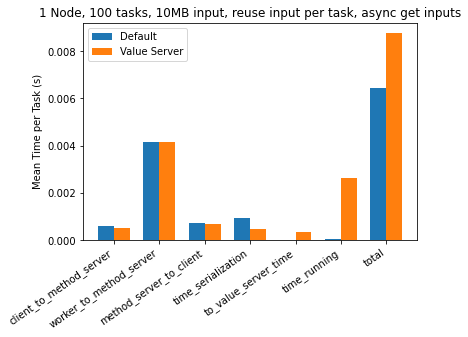

In [418]:
rundir = 'runs/reuse_data_async/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 100 tasks, 10MB input, reuse input per task, async get inputs')
plt.ylabel('Mean Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/unique_data_async/2021-02-12_21-31-37/run...,False,100,10,1,0,1.61317e+09,0,100,0.006625,...,4.623e-05,7.3447e-05,0.000298908,0.000428404,7.96465e-05,0.000611544,0.00422513,0.000842571,0.000899802,0.0244775
1,runs/unique_data_async/2021-02-12_21-33-54/run...,True,100,10,1,0,1.61317e+09,0.000331521,100,0.006813,...,0.00114298,4.13845e-05,0.000187177,0.000212342,3.59975e-05,0.000518918,0.00389242,0.000441551,0.000485799,66.25


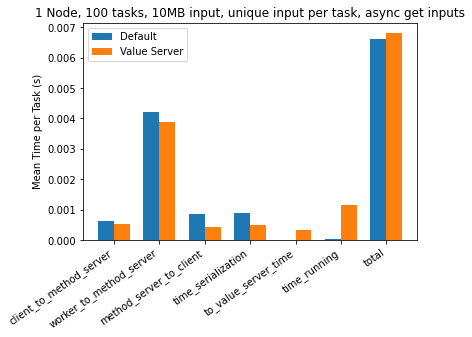

In [419]:
rundir = 'runs/unique_data_async/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 100 tasks, 10MB input, unique input per task, async get inputs')
plt.ylabel('Mean Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()